In [29]:
import pandas as pd # 데이터 분석을 위한 패키지
import numpy as np # 연산을 위한 패키지
import FinanceDataReader as fdr # 주식 데이터를 읽어오는 패키지
import matplotlib.pyplot as plt # 시각화를 위한 패키지

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM 
from tensorflow.keras import optimizers # 최적화 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 기술적 지표를 위한 패키지
import talib

In [2]:
# FinanceDataReader를 이용해 주식 데이터를 읽어옴
# (주식코드, 시작날짜, 끝날짜)
df = fdr.DataReader('005930', start='9/25/2011',end='9/25/2021')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2011-09-26,15200,15740,15180,15500,480907,0.022427
2011-09-27,16100,16100,15820,16080,331600,0.037419
2011-09-28,16480,16500,15820,16140,486551,0.003731
2011-09-29,16080,16960,16080,16740,553981,0.037175
2011-09-30,16600,16800,16220,16800,516023,0.003584


In [12]:
# 현재는 'Date' 컬럼이 데이터프레임의 index로 설정되어 있음
# 이를 'date'라는 별도의 컬럼으로 설정하고, 인덱스는 숫자로 재설정
df['date'] = df.index
df = df.reset_index(drop = True)

In [13]:
# 시계열 데이터로 변환해 주는 함수
def build_timeseries(mat, TIME_STEPS):
    
    dim_0 = mat.shape[0] - TIME_STEPS  # dim_0 = 92 - 3= 89
    dim_1 = mat.shape[1]  # dim_1 = 5

    x = np.zeros((dim_0, TIME_STEPS, dim_1))  # X shape
    y = np.zeros((dim_0,))  # y shape

    # 반복문을 통해 입력값과 출력값을 매칭
    # x는 입력값, y는 타겟 값
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS + i]

        y[i] = mat[TIME_STEPS + i, 0]

    print("length of time-series i/o", x.shape, y.shape)
    
    # 입력값과 출력값을 반환
    return x, y

In [19]:
# 입력 데이터 설정, 총 10개의 입력 값으로 다음 시점의 PM2.5 값을 예측
train_columns = ['Open', 'High','Low','Close','Volume']
# 타겟 컬럼 설정
test_column = ['Close']

# 테스트 데이터의 사이즈 설정
test_set_size = 250
train_set_size = len(df) - test_set_size

# 훈련 데이터 분할
# x_train: 훈련 데이터의 입력 값
# y_train: 훈련 데이터의 타겟 값
x_train = df.loc[0:train_set_size, train_columns].values
y_train = df.loc[0:train_set_size, test_column].values

# 테스트 데이터 분할
# x_test: 테스트 데이터의 입력 값
# y_test: 테스트 데이터의 타겟 값
x_test = df.loc[train_set_size:, train_columns].values
y_test = df.loc[train_set_size:, test_column].values

print("Shape of X train data: ", x_train.shape)
print("Shape of Y train data: ", y_train.shape)

Shape of X train data:  (2215, 5)
Shape of Y train data:  (2215, 1)


In [20]:
# MIN-MAX 스케일러(scaler)
# 전체 값들을 0~1 사이의 값으로 변화해줌 
min_max_scaler = MinMaxScaler()
min_max_scaler_label = MinMaxScaler()

# 훈련 데이터에 대해 스케일링
x_train_scaled = min_max_scaler.fit_transform(x_train)
y_train_scaled = min_max_scaler_label.fit_transform(y_train)

# 테스트 데이터에 대해 스케일링
x_test_scaled = min_max_scaler.transform(x_test)
y_test_scaled = min_max_scaler_label.transform(y_test)

In [26]:
# 시계열 길이를 결정하는 time-step의 값을 5로 설정
# 즉 5개의 과거 데이터를 사용해 다음 값을 예측
time_step = 5

x_train_scaled_time, y_train_scaled_time = build_timeseries(x_train_scaled, time_step)

x_test_scaled_time, y_test_scaled_time = build_timeseries(x_test_scaled, time_step)

print()
print("Shape of x_train_scaled_time: ", x_train_scaled_time.shape)
print("Shape of y_train_scaled_time: ", y_train_scaled_time.shape)

length of time-series i/o (2210, 5, 5) (2210,)
length of time-series i/o (245, 5, 5) (245,)

Shape of x_train_scaled_time:  (2210, 5, 5)
Shape of y_train_scaled_time:  (2210,)


In [27]:
# LSTM + ANN 구조
def create_model(train_X):

    lstm_model = Sequential()
    # LSTM 층: 50개의 노드(node) 개수
    lstm_model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    # 출력층: 1개의 노드
    lstm_model.add(Dense(1))
    
    # 손실함수는 mse(mean squared error)
    # 최적화 함수는 Adam optimizer
    lstm_model.compile(loss='mse', optimizer='adam')

    return lstm_model

In [30]:
# 모델 호출 및 구조 확인
lstm_model = create_model(x_train_scaled_time)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 모델 훈련
# epoch: 학습 횟수 (총 20회 학습)
# batch size: 학습시 입력할 데이터의 개수 (64를 사용)
# validation_split: 훈련 데이터에서 검증 데이터 셋으로 사용할 비율, 0.1 => 10%
history = lstm_model.fit(x_train_scaled_time, y_train_scaled_time, epochs=100, verbose=1, batch_size=64, shuffle=False,
                           validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 8/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 9.9663e-04 - val_loss: 0.0011
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 9.9084e-04 - val_loss: 0.0010

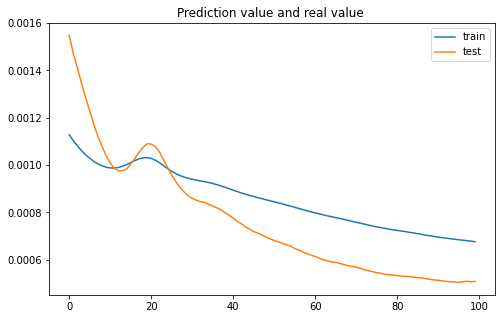

In [37]:
# 훈련 손실과 검증 손실 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Prediction value and real value ")
plt.legend(loc='upper right')

In [38]:
# 훈련된 모델에 테스트 데이터를 입력해 예측
y_predicted = lstm_model.predict(x_test_scaled_time)

# 테스트 데이터는 0~1 사이의 값으로 정규화 되었기 때문에 inverse_transform() 함수를 사용해 원래 가격으로 변환
y_predicted_value = min_max_scaler_label.inverse_transform(y_predicted)
y_test_value = min_max_scaler_label.inverse_transform(y_test_scaled_time.reshape(-1, 1))

In [39]:
# 새로운 Dataframe을 생성
compare_data_new = pd.DataFrame()

# 데이터프레임에 실측치와 예측치를 각각의 컬럼에 저장
compare_data_new['Actual Price'] = y_test_value.flatten()
compare_data_new['Predicted Price'] = np.round(y_predicted_value,1)

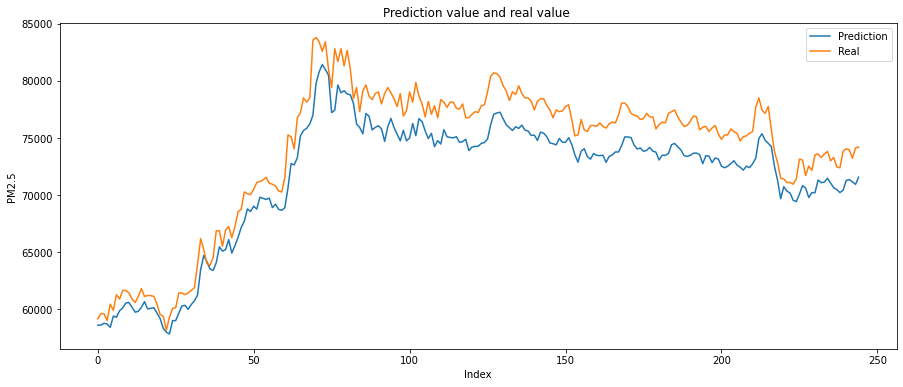

In [40]:
# 실측치와 예측치 그래프
plt.figure(figsize=(15, 6))
plt.plot(y_predicted_value)
plt.plot(y_test_value)
plt.title("Prediction value and real value " )
plt.ylabel('PM2.5')
plt.xlabel("Index")
plt.legend(['Prediction', 'Real'], loc='upper right')